In [1]:
push!(LOAD_PATH, "../src")
using NNQS

using Random, LinearAlgebra
using Flux, Flux.Optimise
using Plots

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/3BCH5/src/backends.jl:43
[ Info: Precompiling ZygoteColorsExt [e68c091a-8ea5-5ca7-be4f-380657d4ad79]
[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [2]:
function run_xxz_exact(L; h, J, Jzz)
    ham = NNQS.HeisenbergChain(h=h, J=J, Jzz=Jzz)
    m = NNQS.matrix(ham, L)
    evals = eigvals(Symmetric(m))
    return evals[1]
end

L = 6
h = 0.7
J = 1
Jzz = 1.3

exact_energy = run_xxz_exact(L, h=h, J=J, Jzz=Jzz)
println("exact energy is ", exact_energy)

exact energy is -10.998339837842467


# Three kinds of batch autoregressive samplers

In [3]:
n_samples=10^10
sampler_a = BatchAutoRegressiveSampler(L, n_sample_per_chain=n_samples)
sampler_b = BatchAutoRegressiveSampler(L, n_sample_per_chain=n_samples, constrain=U1LeafConservation(L, c=div(L,2)))
sampler_c = BatchAutoRegressiveSampler(L, n_sample_per_chain=n_samples, constrain=U1NodeConservation(L, c=div(L,2)))

BatchAutoRegressiveSampler{U1NodeConservation}(U1NodeConservation(6, 3), 6, 10000000000)

# Model: Heiserberg Chain with U(1) symmetry, and parameters

In [4]:
ham = NNQS.HeisenbergChain(h=h, J=J, Jzz=Jzz)
learn_rate = 0.005
epoches = 2000
opt = ADAM(learn_rate)
D = 8

8

1. Batch AutoRegressive Sampling without any constrain

In [5]:
rbm = MPS(Float64, L, D=D)
rbm_a = copy(rbm)

x0, re = Flux.destructure(rbm_a)
losses_a = Float64[]
for i in 1:epoches
    verbosity = (i % 100 == 0) ? 1 : 0
    train_loss, grad = energy_and_grad(ham, rbm_a, sampler_a, n_chain=10, λ=1.0e-6, verbosity=verbosity)

    Optimise.update!(opt, x0, grad)
    rbm_a = re(x0)

    push!(losses_a, train_loss)
    if i % 100 == 0
        println("energy at the $i-th step is $(train_loss).")
    end
end


Ē = -7.302831936199505 ± 2.671709554184516e-5
energy at the 100-th step is -7.302831936199505.
Ē = -9.572657201541201 ± 1.991909903738267e-5
energy at the 200-th step is -9.572657201541201.
Ē = -10.526689597883905 ± 9.41507829539995e-6
energy at the 300-th step is -10.526689597883905.
Ē = -10.786195508602404 ± 1.4253092795341707e-5
energy at the 400-th step is -10.786195508602404.
Ē = -10.862529711113725 ± 1.5868409389456127e-5
energy at the 500-th step is -10.862529711113725.
Ē = -10.924418356898027 ± 1.2660116441024185e-5
energy at the 600-th step is -10.924418356898027.
Ē = -10.952532764526449 ± 5.116168348973671e-6
energy at the 700-th step is -10.952532764526449.
Ē = -10.9640419657511 ± 4.716617919732909e-6
energy at the 800-th step is -10.9640419657511.
Ē = -10.97140779304733 ± 5.465001734420446e-6
energy at the 900-th step is -10.97140779304733.
Ē = -10.97691545169087 ± 4.50350224404291e-6
energy at the 1000-th step is -10.97691545169087.
Ē = -10.981239603252508 ± 3.4

In [6]:
energy_a = energy(ham, rbm_a, sampler_a)
energy_b = energy(ham, rbm_a, sampler_b)
energy_c = energy(ham, rbm_a, sampler_c)
println("energy_a=", energy_a, ", energy_b=", energy_b, ", energy_c=", energy_c)

energy_a=-10.994550805845865, energy_b=-10.99623317152026, energy_c=-10.997313674959583


2. Batch AutoRegressive Sampling with U(1) constrain, but throw samples away

In [7]:
rbm_b = copy(rbm)

x0, re = Flux.destructure(rbm_b)
losses_b = Float64[]
for i in 1:epoches
    verbosity = (i % 100 == 0) ? 1 : 0
    train_loss, grad = energy_and_grad(ham, rbm_b, sampler_b, n_chain=10, λ=1.0e-6, verbosity=verbosity)

    Optimise.update!(opt, x0, grad)
    rbm_b = re(x0)

    push!(losses_b, train_loss)
    if i % 100 == 0
        println("energy at the $i-th step is $(train_loss).")
    end
end

Ē = -9.115768005041154 ± 3.6785883481165444e-5
energy at the 100-th step is -9.115768005041154.
Ē = -10.293135683269258 ± 2.6612875625151304e-5
energy at the 200-th step is -10.293135683269258.
Ē = -10.998155958515563 ± 1.005687582754502e-6
energy at the 300-th step is -10.998155958515563.
Ē = -10.998328866291612 ± 2.498538914296637e-7
energy at the 400-th step is -10.998328866291612.
Ē = -10.998338656798452 ± 6.210450925057824e-8
energy at the 500-th step is -10.998338656798452.
Ē = -10.998339749140166 ± 2.2446694345935774e-8
energy at the 600-th step is -10.998339749140166.
Ē = -10.998339836334733 ± 5.0368372008742944e-9
energy at the 700-th step is -10.998339836334733.
Ē = -10.998339837321037 ± 1.442750209036884e-9
energy at the 800-th step is -10.998339837321037.
Ē = -10.998339837988107 ± 6.618493136194615e-10
energy at the 900-th step is -10.998339837988107.
Ē = -10.998339837790255 ± 3.582307858357036e-10
energy at the 1000-th step is -10.998339837790255.
Ē = -10.998339

In [8]:
energy_a = energy(ham, rbm_b, sampler_a)
energy_b = energy(ham, rbm_b, sampler_b)
energy_c = energy(ham, rbm_b, sampler_c)
println("energy_a=", energy_a, ", energy_b=", energy_b, ", energy_c=", energy_c)

energy_a=-6.151229531196496, energy_b=-10.99833983782175, energy_c=-10.998356362852991


3. Batch AutoRegressive Sampling with U(1) constrain, and normalize number of samples at each node

In [9]:
rbm_c = copy(rbm)

x0, re = Flux.destructure(rbm_c)
losses_c = Float64[]
for i in 1:epoches
    verbosity = (i % 100 == 0) ? 1 : 0
    train_loss, grad = energy_and_grad(ham, rbm_c, sampler_c, n_chain=10, λ=1.0e-6, verbosity=verbosity)

    Optimise.update!(opt, x0, grad)
    rbm_c = re(x0)

    push!(losses_c, train_loss)
    if i % 100 == 0
        println("energy at the $i-th step is $(train_loss).")
    end
end

Ē = -3.957865713970044 ± 0.0001385209129292137
energy at the 100-th step is -3.957865713970044.
Ē = 0.1975460485706242 ± 3.411893574754328e-5
energy at the 200-th step is 0.1975460485706242.
Ē = 0.09616651020566377 ± 4.506419032198399e-5
energy at the 300-th step is 0.09616651020566377.
Ē = -0.025024132122569365 ± 4.5505392859610266e-5
energy at the 400-th step is -0.025024132122569365.
Ē = -0.13736340965833368 ± 3.1385549379882954e-5
energy at the 500-th step is -0.13736340965833368.
Ē = -0.3663222170677431 ± 3.859904016389138e-5
energy at the 600-th step is -0.3663222170677431.
Ē = -0.8526179394262092 ± 6.516171017769056e-5
energy at the 700-th step is -0.8526179394262092.
Ē = -1.1332026181876527 ± 2.540527825238756e-5
energy at the 800-th step is -1.1332026181876527.
Ē = -1.2427587752241906 ± 3.274626555587638e-5
energy at the 900-th step is -1.2427587752241906.
Ē = -1.3484959347603713 ± 3.910338479135604e-5
energy at the 1000-th step is -1.3484959347603713.
Ē = -1.445898

In [10]:
energy_a = energy(ham, rbm_c, sampler_a)
energy_b = energy(ham, rbm_c, sampler_b)
energy_c = energy(ham, rbm_c, sampler_c)
println("energy_a=", energy_a, ", energy_b=", energy_b, ", energy_c=", energy_c)

energy_a=-5.48054603577179, energy_b=-8.395913675360685, energy_c=-7.100172411953111


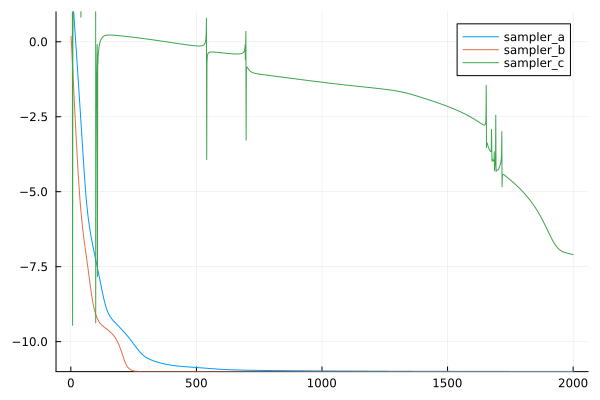

In [14]:
f = plot(losses_a, label="sampler_a")
plot!(f, losses_b, label="sampler_b")
plot!(f, losses_c, label="sampler_c")
ylims!(f, -11, 1)

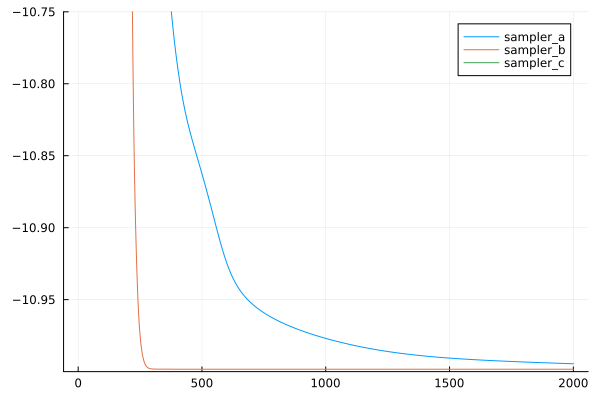

In [16]:
ylims!(f, -11, -10.75)